# Building Ride Share Predictions

<p>This notebook provides the steps our team took to determine if it is ipossible to predict with a certain accuracy the destination of a ride share rental.</p>
<p>To start using Sagemaker go here: <a href="https://aws.amazon.com/sagemaker/">Sagemaker</a></p>
<p>The data we used we obtained from here: https://console.cloud.google.com/marketplace/details/city-of-new-york/nyc-citi-bike <p> 

## Read the whole data from S3

In [121]:
import pandas as pd
import os

In [122]:
bucket = 'data-ml-training'
path = 'data/train/'
training_filename= 'Training_data_original.csv'
training_filename_no_headers = 'Training_data_cleaned_only_numeric_no_headers.csv'
validation_filename = 'validation_data_cleaned_only_numeric_no_headers.csv'
testing_filename = 'test_data_set_with_stop_First.csv'
testing_filename_no_stop = 'test_data_set_with_removed_stop-station.csv'
s3_test_file_path = os.path.join('s3://', bucket, path, testing_filename)
s3_path = os.path.join('s3://', bucket, path, training_filename)

df_all = pd.read_csv(s3_path)

## Start Exploring the data 

In [123]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-whitegrid')
%matplotlib inline

<p>We found data on both the citi bike stations and rides from the stations. 
     We selected the top 10 stations that had the most number of rides. For each of those stations, we exported the top 16,000 rows (sorted by date desc) (16,000 was the limit for exporting).  We kept the most recent 2,000 rides from each station to use as the testing set, and the remaining 14,000 for each as the training set. </p>
We removed the the start time, and end time columns as we were concerned about time and didn't want to convert them to be numeric. We also removed the latitude/longitude of the stop station as it identifes the stop station.
We converted other data columns to their numeric representations. 
    User Type: Subscriber (0) and Customer(1), 
    Gender: female(0), make(1), unknown(2)
        </p>
    


In [120]:
df_all.describe()

,tripduration,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,birth_year
count,1.400000e+05,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,137940.000000
mean,7.753823e+02,672.400000,40.739491,-73.991215,994.320443,40.739509,-73.990958,26056.889229,1977.561657
std,1.383369e+04,837.542268,0.017287,0.010361,1178.275217,0.019682,0.012630,5990.204541,12.741348
min,6.100000e+01,146.000000,40.713126,-74.009106,72.000000,40.657089,-74.017134,14529.000000,1895.000000
25%,3.180000e+02,291.000000,40.729039,-74.000040,335.000000,40.725256,-73.999733,19999.000000,1968.000000
50%,5.320000e+02,478.500000,40.738387,-73.992516,458.000000,40.739355,-73.991026,27875.000000,1979.000000
75%,8.692500e+02,519.000000,40.751873,-73.982614,529.000000,40.751726,-73.982681,31205.000000,1988.000000
max,4.845321e+06,3158.000000,40.771639,-73.975739,3686.000000,40.814394,-73.912555,33689.000000,2002.000000


### Geographic 

In [92]:
nyc_box = (-74.1, -73.7, 40.6, 40.9)

In [93]:
def filter_coordinates(df, box):
    return (df.start_station_longitude >= box[0]) & (df.start_station_longitude <= box[1]) & \
           (df.start_station_latitude >= box[2]) & (df.start_station_latitude <=box[3]) & \
           (df.end_station_longitude >= box[0]) & (df.end_station_longitude <= box[1]) & \
           (df.end_station_latitude >= box[2]) & (df.end_station_latitude <= box[3])

In [94]:
def plot_hires(df, box, figsize=(12, 12), ax=None, c=sns.color_palette("husl", 2)):
    if ax == None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    idx = filter_coordinates(df, box)
    ax.scatter(df[idx].start_station_longitude, df[idx].start_station_latitude, c=c[0], s=0.1, lw=0.1, alpha=0.5)
    ax.scatter(df[idx].end_station_longitude, df[idx].end_station_latitude, c=c[1], s=0.1, lw=0.1, alpha=0.5)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


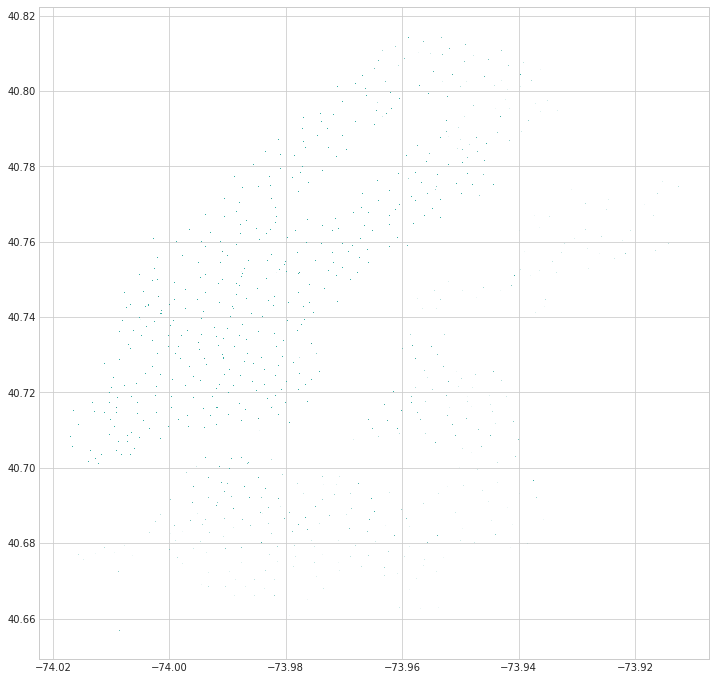

In [95]:
plot_hires(df_all, nyc_box)

<p>In the scatter plot above, it seems that there is a lot of variation in the destinations of the 10 stations that are are looking at.</p>

## Train model 

In [36]:
from sagemaker.amazon.amazon_estimator import get_image_uri
import sagemaker
from sagemaker import get_execution_role
import boto3
from datetime import datetime

In [37]:
path_train = os.path.join(path, training_filename_no_headers)
print(path_train)
path_validation = os.path.join(path, validation_filename)
print(path_test)

data/train/Training_data_cleaned_only_numeric_no_headers.csv
data/train/testing_data_cleaned_only_numeric_no_headers.csv


In [38]:
container = get_image_uri(boto3.Session().region_name, 'xgboost')

In [39]:
train_channel = sagemaker.session.s3_input('s3://{}/{}'.format(bucket, path_train), content_type='text/csv')
print(train_channel)
validation_channel = sagemaker.session.s3_input(s3_data='s3://{}/{}'.format(bucket, path_test), content_type='text/csv')
print(validation_channel)
data_channels = {'train': train_channel, 'validation': validation_channel}


In [40]:
sess = sagemaker.Session()
print(sess)
role = get_execution_role()
print(role)

arn:aws:iam::023375022819:role/service-role/AmazonSageMaker-ExecutionRole-20190520T113312


In [26]:
training_job_path = os.path.join('training_jobs', datetime.now().strftime('%Y-%m-%d-%H-%M-%S'))
print(training_job_path)

training_jobs/2019-06-20-13-48-05


In [124]:

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=4, 
                                    train_instance_type='ml.m4.16xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket,training_job_path),
                                    sagemaker_session=sess)

In [125]:
's3://{}/{}/output'.format(bucket,training_job_path)
print('s3://{}/{}/output'.format(bucket,training_job_path))

s3://data-ml-training/training_jobs/2019-06-20-13-48-05/output


In [126]:
#we want to use classifier model
xgb.set_hyperparameters(max_depth=9,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=300,
                        subsample=0.8,
                        silent=0,
                        objective='multi:softmax',
                        early_stopping_rounds=10,
                        num_round=10000,
                        eval_metric='error',
                        num_class=3686  #THIS IS THE NUMBER IS CURRENTLY THE HIGHTEST STATION NUMBER. In order for this to work, we need to find all the station numbers (there are 856) and assign them a value so that they are sequential 
                       )


In [ ]:
xgb.fit(inputs=data_channels,logs=True)

2019-06-20 17:20:45 Starting - Starting the training job...
2019-06-20 17:21:13 Starting - Launching requested ML instances.....

## Deploy the model 

To deploy the model we move to the Amazon Sagemaker console and perform the following steps: <br>
1) Create model <br>
2) Create an endpoint configuration <br>
3) create and endpoint <br>

In [ ]:
training_job_name='stop-estimator'
xgb_predictor = xgb.deploy(initial_instance_count=1, instance_type='ml.m4.16xlarge', endpoint_name='stop-estimator')
print(xgb_predictor)

## Evaluate results 

Parts taken from here:<br>
https://aws.amazon.com/blogs/machine-learning/simplify-machine-learning-with-xgboost-and-amazon-sagemaker/

In [50]:
from sagemaker.predictor import csv_serializer

In [58]:
s3_validation_file_path = os.path.join('s3://', bucket, path, validation_filename)
df_test = pd.read_csv(s3_test_file_path, header=None)
#print(df_test)

In [105]:
df_test.head()

,0,1,2,3,4,5,6,7,8
0,238,867,146,40.71625,-74.009106,20224,0,1963,1
1,280,942,146,40.71625,-74.009106,30224,0,1988,1
2,327,176,146,40.71625,-74.009106,21675,0,1980,1
3,257,1075,146,40.71625,-74.009106,19464,1,1994,1
4,257,275,146,40.71625,-74.009106,15015,0,1967,0


In [92]:
from sagemaker.predictor import csv_serializer

989.685913086


In [ ]:
df_test = pd.read_csv('./df_val.csv', header=None)

In [ ]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

data_row = '867,146,40.71625008,-74.0091059,20224,0,1963,1' #stop station should be 238
prediction = xgb_predictor.predict(data_row).decode('utf-8')
printf(prediction)


In [ ]:
#df_val = pd.DataFrame()
#df_val['prediction'] = predictions
#df_val['target'] = df_test[0]

In [ ]:
#plt.figure(figsize=(15,6))
#sns.regplot(x=df_val["target"], y=df_val["prediction"])
#plt.show()

In [ ]:
#df_val['err'] = (df_val["target"] - df_val["prediction"])

In [ ]:
#df_val['err'].plot(kind='hist', bins=100, range=(-6,10), alpha=0.8, figsize=(15,6))
#plt.show()

In [ ]:
#df_val.describe()

## Make online predictions

In [129]:
#import ast

In [93]:
#s3_test_file_path = os.path.join('s3://', bucket, path, testing_filename)
#df = pd.read_csv(s3_test_file_path, header=None)

#n = 100
#features = df.iloc[0:n,1:].values
#values  = df.iloc[0:n,0].values

In [94]:
#endpoint_name = 'stop-estimator'
#content_type = 'text/csv'
#data = "\n".join(["\n".join([",".join(str(x) for x in sample)]) for sample in features])

#runtime = boto3.Session().client('sagemaker-runtime')
#response = runtime.invoke_endpoint(EndpointName=endpoint_name,\
                                   ContentType='text/csv',\
                                   Body=data) 

In [95]:
#result = list(ast.literal_eval(response['Body'].read().decode()))
#print(result)

[819.569824219, 809.488769531, 937.75793457, 683.728393555, 506.584106445, 760.766418457, 1012.57000732, 694.06237793, 795.413818359, 960.243896484, 1025.74645996, 1213.28271484, 672.603637695, 659.989868164, 876.671264648, 846.451660156, 299.80670166, 627.646911621, 639.306518555, 1493.19274902, 618.689086914, 958.653808594, 816.840942383, 1740.96325684, 1017.63519287, 189.477386475, 683.831359863, 681.40435791, 1044.14074707, 1379.19543457, 743.624145508, 912.439758301, 1079.5769043, 720.27935791, 838.542358398, 876.488586426, 994.151245117, 606.531677246, 2105.13549805, 695.045654297, 894.431945801, 827.769836426, 1047.74255371, 694.997802734, 668.020812988, 1127.84179688, 791.560058594, 386.061157227, 846.602233887, 857.422302246, 898.054138184, 1069.08825684, 572.028015137, 729.142089844, 792.346557617, 850.423828125, 901.610107422, 1100.79296875, 1145.59423828, 703.697753906, 738.699584961, 888.224243164, 1324.30761719, 535.263000488, 802.512145996, 868.434020996, 920.234863281, 